## 2nd Section: Selection of a machine learning algorithm

For memory reasons, I need to split Notebooks.
In this one I will only treat the selection of a classifier algorithm, in the next one it will be about optimizing and testing it agains the test set.

### Import libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Additional libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore")

import time

### Part 3: Machine learning pipeline

For this section I will use the 2017 file to train (and test) the model. Ideally I can then use the model on the 2018 data and predict companies going out of business before having the results (and hence test my model by contacting directly companies and try it out !)

#### 3.1 Load dataset and perform one transformation

In [4]:
## Quick function to load the data and make the few transformations
def load_transform(filepath):
    '''
    Quick function to load the data and drop one column
    INPUT:
    filepath of data to be loaded
    OUTPUT:
    dataframe ready for ML Pipeline
        '''
    
    # load dataframe
    df = pd.read_csv(filepath, sep = ";")
    
    # drop column coming from saving date
    df.drop("Unnamed: 0", axis = 1, inplace = True)
    
    return df

In [5]:
# Load 2017 data
df = load_transform("cleaned_data_2017.csv")

#### 3.2 Prepare X, y as well as training and testing set

In [6]:
# Function to prepare training and testing set
def prep_train_test(df, test_size = 0.25):
    '''
    Extract X and y, Split data into training and testing set
    INPUT:
    df: dataframe
    test_size (float): share of testing set 
    OUTPUT:
    X_train, X_test, y_train, y_test
    '''
    
    # Extract X and y
    y = df['rad'].values
    X = df.drop(['rad', 'siren'], axis = 1).values
    
    # Split training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 1)
    
    return X_train, X_test, y_train, y_test
    

In [7]:
# Prepare training and testing set
X_train, X_test, y_train, y_test = prep_train_test(df)

#### 3.3 Model selection

Using a function to run over different classifiers, I will test which algorithm looks the best for this particular task

In [9]:
# Write a function to test different classifiers to see which one works best in our case

def train_evaluate_model(X_train, y_train):
    '''
    Function to test various classifiers and get best one
    INPUT:
    X_train, y_train: data to be trained on
    OUTPUT:
    Name of best classifier and performance (accuracy and precision)

    '''
    
    # Fist scale data before training
    scale = StandardScaler().fit(X_train)
    X_train_scaled = scale.transform(X_train)
    X_test_scaled = scale.transform(X_test)

    # Define classifiers to be tested
    classifiers = [
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        AdaBoostClassifier(),
        GradientBoostingClassifier(),
        GaussianNB(),
        LinearDiscriminantAnalysis()
    ]

    # Logging for Visual Comparison
    log_cols=["Classifier", "Accuracy", "Precision", "Training_time"]
    log = pd.DataFrame(columns=log_cols)

    # Loop through the classifiers, train and show performance on training set
    for clf in classifiers:

        print("="*30) # separator
        
        # Get and print name of classifier being tested
        name = clf.__class__.__name__
        print(name)

        # Train classifier
        start = time.time()
        clf.fit(X_train_scaled, y_train)
        training_time = time.time() - start

        # Display results
        print('****Results****')
        
        train_predictions = clf.predict(X_test_scaled) # predict on test set
        
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))

        prec = precision_score(y_test, train_predictions)
        print("Precision: {:.4%}".format(prec))
        
        print("Training time: ", np.round(training_time,0))

        log_entry = pd.DataFrame([[name, acc*100, prec*100, training_time]], columns=log_cols)
        log = log.append(log_entry)

    print("="*30)
    
    return log

In [10]:
# Run function
best_model = train_evaluate_model(X_train, y_train)

RandomForestClassifier
****Results****
Accuracy: 97.4068%
Precision: 10.4167%
Training time:  108.0
DecisionTreeClassifier
****Results****
Accuracy: 95.2959%
Precision: 4.0473%
Training time:  137.0
AdaBoostClassifier
****Results****
Accuracy: 97.6510%
Precision: 0.0000%
Training time:  229.0
GradientBoostingClassifier
****Results****
Accuracy: 97.6468%
Precision: 0.0000%
Training time:  750.0
GaussianNB
****Results****
Accuracy: 4.6710%
Precision: 2.3722%
Training time:  4.0
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.6510%
Precision: 0.0000%
Training time:  41.0


In [31]:
# Compute basis performance
acc_basis = 1-y_train.mean()
prec_basis = 1-acc_basis
print("Basic accuracy without model on the training set: {} %".format(np.round(acc_basis * 100,3)))
print("Basic precision without model on the training set: {} %".format(np.round(prec_basis * 100,3)))

Basic accuracy without model on the training set: 97.633 %
Basic precision without model on the training set: 2.367 %


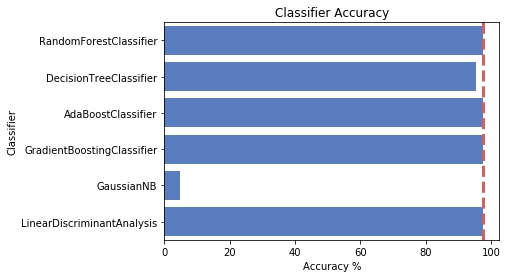

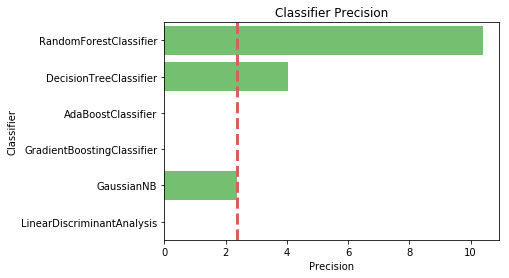

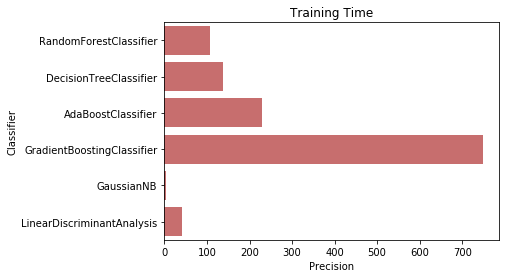

In [40]:
# Show performance graphically
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=best_model, color="b")

plt.xlabel('Accuracy %')
plt.axvline(x=acc_basis*100,linewidth=3, color = 'r', ls = '--')
plt.title('Classifier Accuracy')
plt.savefig("classifier_accuracy.png", bbox_inches = 'tight')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=best_model, color="g")

plt.xlabel('Precision')
plt.axvline(x=prec_basis*100,linewidth=3, color = 'r', ls = '--')
plt.title('Classifier Precision')
plt.savefig("classifier_precision.png", bbox_inches = 'tight')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Training_time', y='Classifier', data=best_model, color="r")

plt.xlabel('Precision')
plt.title('Training Time')
plt.savefig("classifier_training_time.png", bbox_inches = 'tight')
plt.show()


**CONCLUSION** 

Looking at the performance of the tested non-optimized models, the Random forest classifier looks the best model for our purpose as its precision is very high compared to the others (what we are looking for) and ca. 4 times better than an random choice (our so called basic precision).

In the next section I will then try to further optimize a random forest classifier using GridSearchCV and finally test it against the testing set.